<a href="https://colab.research.google.com/github/Yogesh914/emogo-ml/blob/main/vivit_distributions_beta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install av

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 44.6 MB/s eta 0:00:00


In [1]:
import torch
from transformers import VivitConfig, VivitModel, VivitImageProcessor
from huggingface_hub import hf_hub_download
import numpy as np
import os
import pandas as pd
import av
import cv2
import dlib
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [2]:
def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])



def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

In [3]:
def crop_face(frame, face_detector):
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    faces = face_detector(gray, 1)
    if len(faces) > 0:
        face = faces[0]
        left, top, right, bottom = face.left(), face.top(), face.right(), face.bottom()
        cropped_frame = frame[top:bottom, left:right]
        return cropped_frame
    else:
        return None

In [5]:
np.random.seed(0)

file_path = os.path.join('/content/drive/MyDrive/data/beta_vids/10067_07.mp4')
container = av.open(file_path)

face_detector = dlib.get_frontal_face_detector()


# sample 32 frames
indices = sample_frame_indices(clip_len=32, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container=container, indices=indices)

cropped_video = []
for frame in video:
    cropped_frame = crop_face(frame, face_detector)
    if cropped_frame is not None:
        cropped_video.append(cropped_frame)

# Pad the cropped video if it has fewer than 32 frames
while len(cropped_video) < 32:
    cropped_video.append(np.zeros_like(cropped_video[0]))

image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2")
model = VivitModel.from_pretrained("google/vivit-b-16x2")

# prepare video for the model
inputs = image_processor(list(cropped_video), return_tensors="pt")

# forward pass
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state
list(last_hidden_states.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/22.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/356M [00:00<?, ?B/s]

Some weights of VivitModel were not initialized from the model checkpoint at google/vivit-b-16x2 and are newly initialized: ['vivit.pooler.dense.bias', 'vivit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(value)


[1, 3137, 768]

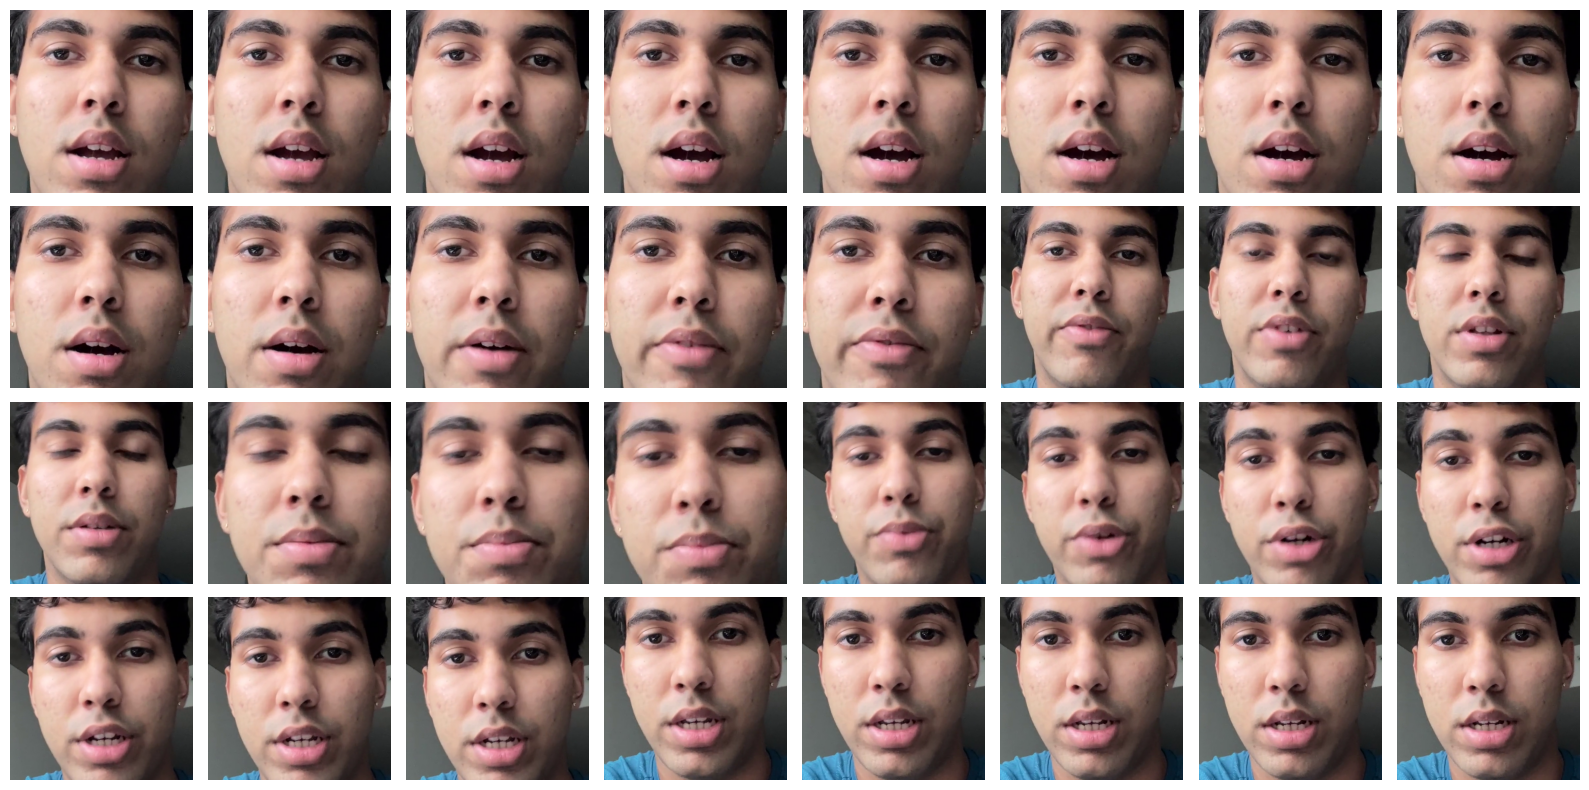

In [6]:
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    if i < len(cropped_video):
        ax.imshow(cropped_video[i])
    ax.axis('off')
plt.tight_layout()
plt.show()

Some weights of VivitModel were not initialized from the model checkpoint at google/vivit-b-16x2 and are newly initialized: ['vivit.pooler.dense.bias', 'vivit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.tensor(value)


Insufficient face frames detected in video: /content/drive/MyDrive/data/beta_vids/10073_07.mp4
Insufficient face frames detected in video: /content/drive/MyDrive/data/beta_vids/10073_11.mp4
Insufficient face frames detected in video: /content/drive/MyDrive/data/beta_vids/10073_47.mp4
Insufficient face frames detected in video: /content/drive/MyDrive/data/beta_vids/10073_51.mp4
Insufficient face frames detected in video: /content/drive/MyDrive/data/beta_vids/10073_54.mp4


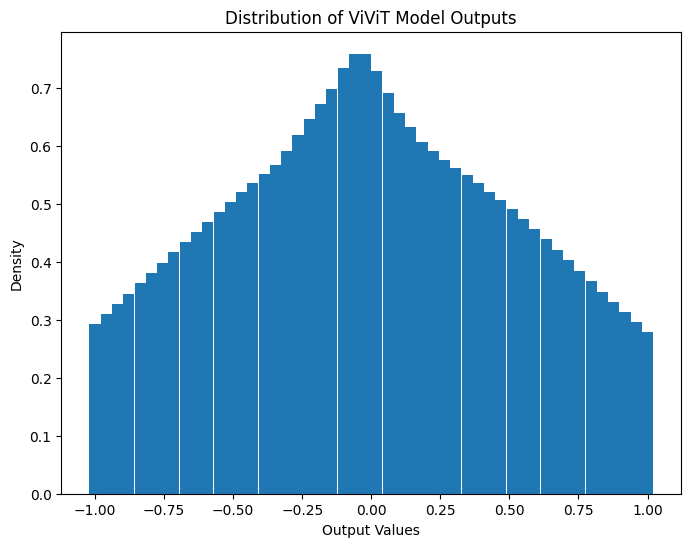

In [4]:
def process_video(file_path, face_detector, image_processor, model, num_frames=32):
    container = av.open(file_path)

    # Sample more frames from the video
    indices = sample_frame_indices(clip_len=num_frames*2, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
    video = read_video_pyav(container=container, indices=indices)

    cropped_video = []
    for frame in video:
        cropped_frame = crop_face(frame, face_detector)
        if cropped_frame is not None:
            cropped_video.append(cropped_frame)

    if len(cropped_video) < num_frames:
        print(f"Insufficient face frames detected in video: {file_path}")
        return None

    # Select 32 frames with detected faces
    selected_frames = cropped_video[:num_frames]

    # Pad or truncate the selected frames to ensure a consistent length
    if len(selected_frames) < num_frames:
        # Pad with zeros if there are fewer than 32 frames
        padded_frames = selected_frames + [np.zeros_like(selected_frames[0]) for _ in range(num_frames - len(selected_frames))]
    else:
        # Truncate to 32 frames if there are more than 32 frames
        padded_frames = selected_frames[:num_frames]

    try:
      inputs = image_processor(list(padded_frames), return_tensors="pt")
    except ZeroDivisionError as e:
      print(f"Insufficient face frames detected in video: {file_path}")
      return None

    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    return last_hidden_states

# Set the path to the folder containing the video files
video_folder = '/content/drive/MyDrive/data/beta_vids'

# Load the face detector, image processor, and model
face_detector = dlib.get_frontal_face_detector()
image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2")
model = VivitModel.from_pretrained("google/vivit-b-16x2")
video_files = [filename for filename in os.listdir(video_folder) if filename.endswith('.mp4')]


selected_videos = video_files

# Initialize the histogram
hist_range = (-1, 1)
hist_bins = 50
hist = np.zeros(hist_bins)

# Loop over the selected videos and update the histogram incrementally
for filename in selected_videos:
    file_path = os.path.join(video_folder, filename)
    outputs = process_video(file_path, face_detector, image_processor, model)
    if outputs is not None:
        hist += np.histogram(outputs.detach().cpu().numpy().flatten(), bins=hist_bins, range=hist_range)[0]

# Normalize the histogram to obtain density values
hist = hist / (hist.sum() * (hist_range[1] - hist_range[0]) / hist_bins)

# Plot the distribution of the outputs
plt.figure(figsize=(8, 6))
plt.bar(np.linspace(hist_range[0], hist_range[1], hist_bins), hist, width=(hist_range[1] - hist_range[0]) / hist_bins)
plt.xlabel('Output Values')
plt.ylabel('Density')
plt.title('Distribution of ViViT Model Outputs')
plt.show()